<a href="https://colab.research.google.com/github/ykitaguchi77/AdvancedPytorch_Colab/blob/master/Advanced_pytorch_%E8%BB%A2%E7%A7%BB%E5%AD%A6%E7%BF%92_AppleStrawberry1.1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Advanced Pytorch 転移学習

Apple Strawberryの識別



https://github.com/YutaroOgawa/pytorch_advanced/blob/master/1_image_classification/1-3_transfer_learning.ipynb

In [0]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

#Advanced Pytorchから
import glob
import os.path as osp
import random
import numpy as np
import json
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import models, transforms

#ukiyoeから
import matplotlib.pyplot as plt

from torch.autograd import Variable


plt.ion()   # interactive mode




In [0]:
# 乱数のシードを設定
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

#DataSetの作成

In [15]:
'''
－－－－－－－－－－－－－－
アップデータするデータの構造
dataset.zip --data--hymenoptera_data---------apple
                                                 |----strawberry
－－－－－－－－－－－－－－
'''                                     

#google driveをcolabolatoryにマウント
from google.colab import drive
drive.mount('/content/drive')

#dataset.zipを解凍

!date -R
!unzip -qq drive/My\ Drive/applstra.zip
!date -R
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Sat, 11 Jan 2020 00:53:39 +0000
replace data/bennetts-wallaby-01.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
Sat, 11 Jan 2020 00:53:49 +0000
data  drive  sample_data  utils


In [0]:
# 入力画像の前処理をするクラス
# 訓練時と推論時で処理が異なる


class ImageTransform():
    """
    画像の前処理クラス。訓練時、検証時で異なる動作をする。
    画像のサイズをリサイズし、色を標準化する。
    訓練時はRandomResizedCropとRandomHorizontalFlipでデータオーギュメンテーションする。


    Attributes
    ----------
    resize : int
        リサイズ先の画像の大きさ。
    mean : (R, G, B)
        各色チャネルの平均値。
    std : (R, G, B)
        各色チャネルの標準偏差。
    """

    def __init__(self, resize, mean, std):
        self.data_transform = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop(
                    resize, scale=(0.5, 1.0)),  # データオーギュメンテーション
                transforms.RandomHorizontalFlip(),  # データオーギュメンテーション
                transforms.ToTensor(),  # テンソルに変換
                transforms.Normalize(mean, std)  # 標準化
            ]),
            'val': transforms.Compose([
                transforms.Resize(resize),  # リサイズ
                transforms.CenterCrop(resize),  # 画像中央をresize×resizeで切り取り
                transforms.ToTensor(),  # テンソルに変換
                transforms.Normalize(mean, std)  # 標準化
            ])
        }

    def __call__(self, img, phase='train'):
        """
        Parameters
        ----------
        phase : 'train' or 'val'
            前処理のモードを指定。
        """
        return self.data_transform[phase](img)

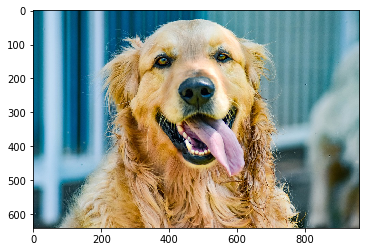

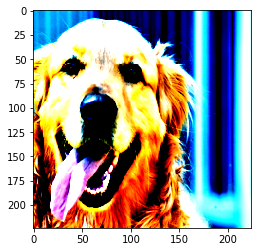

In [18]:
# 訓練時の画像前処理の動作を確認
# 実行するたびに処理結果の画像が変わる

# 1. 画像読み込み
image_file_path = '/content/data/goldenretriever-3724972_640.jpg'
img = Image.open(image_file_path)   # [高さ][幅][色RGB]

# 2. 元の画像の表示
plt.imshow(img)
plt.show()

# 3. 画像の前処理と処理済み画像の表示
size = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

transform = ImageTransform(size, mean, std)
img_transformed = transform(img, phase="train")  # torch.Size([3, 224, 224])

# (色、高さ、幅)を (高さ、幅、色)に変換し、0-1に値を制限して表示
img_transformed = img_transformed.numpy().transpose((1, 2, 0))
img_transformed = np.clip(img_transformed, 0, 1)
plt.imshow(img_transformed)
plt.show()

In [19]:
# アリとハチの画像へのファイルパスのリストを作成する


def make_datapath_list(phase="train"):
    """
    データのパスを格納したリストを作成する。

    Parameters
    ----------
    phase : 'train' or 'val'
        訓練データか検証データかを指定する

    Returns
    -------
    path_list : list
        データへのパスを格納したリスト
    """

    rootpath = "/content/data/hymenoptera_data/"
    target_path = osp.join(rootpath+phase+'/**/*.jpg')
    print(target_path)

    path_list = []  # ここに格納する

    # globを利用してサブディレクトリまでファイルパスを取得する
    for path in glob.glob(target_path):
        path_list.append(path)

    return path_list


# 実行
train_list = make_datapath_list(phase="train")
val_list = make_datapath_list(phase="val")

#データの詳細を表示
#train_list
class_num = len(os.listdir(path='/content/data/hymenoptera_data/train'))
class_name = os.listdir(path='/content/data/hymenoptera_data/train')
print(class_name)
k=0
for i in class_name:
    print(class_name[k]+"_train:"+str(len(os.listdir(path='/content/data/hymenoptera_data/train/'+class_name[k]))))
    k+=1
k=0
for i in class_name:
    print(class_name[k]+"_val:"+str(len(os.listdir(path='/content/data/hymenoptera_data/val/'+class_name[k]))))
    k+=1

print("training data set_total："+ str(len(train_list)))
print("validating data set_total："+str(len(val_list)))

/content/data/hymenoptera_data/train/**/*.jpg
/content/data/hymenoptera_data/val/**/*.jpg
['appl', 'stra']
appl_train:252
stra_train:252
appl_val:67
stra_val:60
training data set_total：497
validating data set_total：124


In [22]:
# イチゴとリンゴの画像のDatasetを作成する


class HymenopteraDataset(data.Dataset):
    """
    アリとハチの画像のDatasetクラス。PyTorchのDatasetクラスを継承。

    Attributes
    ----------
    file_list : リスト
        画像のパスを格納したリスト
    transform : object
        前処理クラスのインスタンス
    phase : 'train' or 'test'
        学習か訓練かを設定する。
    """

    def __init__(self, file_list, transform=None, phase='train'):
        self.file_list = file_list  # ファイルパスのリスト
        self.transform = transform  # 前処理クラスのインスタンス
        self.phase = phase  # train or valの指定

    def __len__(self):
        '''画像の枚数を返す'''
        return len(self.file_list)

    def __getitem__(self, index):
        '''
        前処理をした画像のTensor形式のデータとラベルを取得
        '''

        # index番目の画像をロード
        img_path = self.file_list[index]
        img = Image.open(img_path)  # [高さ][幅][色RGB]

        # 画像の前処理を実施
        img_transformed = self.transform(
            img, self.phase)  # torch.Size([3, 224, 224])

        # 画像のラベルをファイル名から抜き出す
        if self.phase == "train":
            label = img_path[37:41]
        elif self.phase == "val":
            label = img_path[35:39]

        # ラベルを数値に変更する
        k=0
        for i in class_name: 
          if label == (class_name[k])[0:4]:
              label = k
          k+= 1

        return img_transformed, label


# 実行
train_dataset = HymenopteraDataset(
    file_list=train_list, transform=ImageTransform(size, mean, std), phase='train')

val_dataset = HymenopteraDataset(
    file_list=val_list, transform=ImageTransform(size, mean, std), phase='val')

# 動作確認
index = 0
print(train_dataset.__getitem__(index)[0].size())
print(train_dataset.__getitem__(index)[1])

torch.Size([3, 224, 224])
0


In [25]:
#テンソルサイズの確認 (実行不要)
print(train_list[192])
print(train_dataset[192].__getitem__(index)[0].size())

print("train_list")
k=0
for i in range(len(train_list)):
    print(train_dataset[k].__getitem__(index)[0].size())
    k+=1
    print(k)

print("val_list")
k=0
for i in range(len(val_list)):
    print(val_dataset[k].__getitem__(index)[0].size())
    k+=1
    print(k)

/content/data/hymenoptera_data/train/appl/2018-10-sm-kt01.jpg
torch.Size([224, 224])
train_list
torch.Size([224, 224])
1
torch.Size([224, 224])
2
torch.Size([224, 224])
3
torch.Size([224, 224])
4
torch.Size([224, 224])
5
torch.Size([224, 224])
6
torch.Size([224, 224])
7
torch.Size([224, 224])
8
torch.Size([224, 224])
9
torch.Size([224, 224])
10
torch.Size([224, 224])
11
torch.Size([224, 224])
12
torch.Size([224, 224])
13
torch.Size([224, 224])
14
torch.Size([224, 224])
15
torch.Size([224, 224])
16
torch.Size([224, 224])
17
torch.Size([224, 224])
18
torch.Size([224, 224])
19
torch.Size([224, 224])
20
torch.Size([224, 224])
21
torch.Size([224, 224])
22
torch.Size([224, 224])
23
torch.Size([224, 224])
24
torch.Size([224, 224])
25
torch.Size([224, 224])
26
torch.Size([224, 224])
27
torch.Size([224, 224])
28
torch.Size([224, 224])
29
torch.Size([224, 224])
30
torch.Size([224, 224])
31
torch.Size([224, 224])
32
torch.Size([224, 224])
33
torch.Size([224, 224])
34
torch.Size([224, 224])
35
tor

In [26]:
# ミニバッチのサイズを指定
batch_size = 8

# DataLoaderを作成 ※original scriptではval_dataloaderのshuffleはtrue
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=True)

# 辞書型変数にまとめる
dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}

# 動作確認
batch_iterator = iter(dataloaders_dict["train"])  # イテレータに変換
inputs, labels = next(
    batch_iterator)  # 1番目の要素を取り出す
print(inputs.size())
print(labels)

torch.Size([8, 3, 224, 224])
tensor([0, 1, 1, 1, 1, 0, 0, 0])


#Train datasetのいくつかを表示する

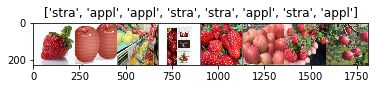

In [27]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(train_dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_name[x] for x in classes])

In [28]:
# 学習済みのVGG-16モデルをロード
# VGG-16モデルのインスタンスを生成
use_pretrained = True  # 学習済みのパラメータを使用
net = models.vgg16(pretrained=use_pretrained)

# VGG16の最後の出力層の出力ユニットをアリとハチの2つに付け替える
net.classifier[6] = nn.Linear(in_features=4096, out_features=2)

# 訓練モードに設定
net.train()

print('ネットワーク設定完了：学習済みの重みをロードし、訓練モードに設定しました')

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:18<00:00, 30.7MB/s]


ネットワーク設定完了：学習済みの重みをロードし、訓練モードに設定しました


In [29]:
#実行不要
print(net)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:
# 損失関数の設定
criterion = nn.CrossEntropyLoss()

In [31]:
# 転移学習で学習させるパラメータを、変数params_to_updateに格納する
params_to_update = []

# 学習させるパラメータ名
update_param_names = ["classifier.6.weight", "classifier.6.bias"]

# 学習させるパラメータ以外は勾配計算をなくし、変化しないように設定
for name, param in net.named_parameters():
    if name in update_param_names:
        param.requires_grad = True
        params_to_update.append(param)
        print(name)
    else:
        param.requires_grad = False

# params_to_updateの中身を確認
print("-----------")
print(params_to_update)

classifier.6.weight
classifier.6.bias
-----------
[Parameter containing:
tensor([[-0.0053, -0.0133, -0.0080,  ...,  0.0083, -0.0070, -0.0044],
        [ 0.0128, -0.0116, -0.0136,  ...,  0.0077,  0.0052,  0.0002]],
       requires_grad=True), Parameter containing:
tensor([0.0069, 0.0115], requires_grad=True)]


In [0]:
optimizer = optim.SGD(params=params_to_update, lr=0.001, momentum=0.9)

In [0]:
# モデルを学習させる関数を作成
def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):

    #deviceをGPUに設定、ランタイムをGPUに変更しておく
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("使用デバイス：", device)
    #ネットワークをGPUへ
    net.to(device)

    #ネットワークがある程度固定であれば、高速化させる
    torch.backends.cudnn.benchmark = True

    # epochのループ
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-------------')

        # epochごとの学習と検証のループ
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train()  # モデルを訓練モードに
            else:
                net.eval()   # モデルを検証モードに

            epoch_loss = 0.0  # epochの損失和
            epoch_corrects = 0  # epochの正解数

            # 未学習時の検証性能を確かめるため、epoch=0の訓練は省略
            if (epoch == 0) and (phase == 'train'):
                continue

            # データローダーからミニバッチを取り出すループ
            for inputs, labels in tqdm(dataloaders_dict[phase]):

                #GPUを用いるための処理
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # optimizerを初期化
                optimizer.zero_grad()

                # 順伝搬（forward）計算
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = net(inputs)
                    loss = criterion(outputs, labels)  # 損失を計算
                    _, preds = torch.max(outputs, 1)  # ラベルを予測
                    
  
                    # 訓練時はバックプロパゲーション
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    # イタレーション結果の計算
                    # lossの合計を更新
                    epoch_loss += loss.item() * inputs.size(0)  
                    # 正解数の合計を更新
                    epoch_corrects += torch.sum(preds == labels.data)

            # epochごとのlossと正解率を表示
            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_acc = epoch_corrects.double(
            ) / len(dataloaders_dict[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

In [34]:
# 学習・検証を実行する
num_epochs=8
train_model(net, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)

使用デバイス： cuda:0


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 1/8
-------------


  0%|          | 0/63 [00:00<?, ?it/s]

val Loss: 0.6723 Acc: 0.5323
Epoch 2/8
-------------


  0%|          | 0/16 [00:00<?, ?it/s]

train Loss: 0.1569 Acc: 0.9356


  2%|▏         | 1/63 [00:00<00:08,  7.41it/s]

val Loss: 0.0254 Acc: 0.9919
Epoch 3/8
-------------


  0%|          | 0/16 [00:00<?, ?it/s]

train Loss: 0.0667 Acc: 0.9698


  2%|▏         | 1/63 [00:00<00:08,  7.16it/s]

val Loss: 0.0292 Acc: 0.9839
Epoch 4/8
-------------


  6%|▋         | 1/16 [00:00<00:02,  5.88it/s]

train Loss: 0.0446 Acc: 0.9799


  2%|▏         | 1/63 [00:00<00:12,  5.15it/s]

val Loss: 0.0178 Acc: 0.9919
Epoch 5/8
-------------


  6%|▋         | 1/16 [00:00<00:01,  9.38it/s]

train Loss: 0.0434 Acc: 0.9839


  0%|          | 0/63 [00:00<?, ?it/s]

val Loss: 0.0205 Acc: 0.9919
Epoch 6/8
-------------


  6%|▋         | 1/16 [00:00<00:02,  7.04it/s]

train Loss: 0.0357 Acc: 0.9920


  0%|          | 0/63 [00:00<?, ?it/s]

val Loss: 0.0133 Acc: 0.9919
Epoch 7/8
-------------


  6%|▋         | 1/16 [00:00<00:01,  7.51it/s]

train Loss: 0.0319 Acc: 0.9819


  2%|▏         | 1/63 [00:00<00:07,  7.75it/s]

val Loss: 0.0118 Acc: 0.9919
Epoch 8/8
-------------


  6%|▋         | 1/16 [00:00<00:02,  6.58it/s]

train Loss: 0.0220 Acc: 0.9960


100%|██████████| 16/16 [00:02<00:00,  6.34it/s]

val Loss: 0.0237 Acc: 0.9839


#予測結果を表示するためのコード

In [38]:
dataiter = iter(val_dataloader)
images, labels = dataiter.next()

#print(images)
print(labels)

tensor([1, 0, 0, 1, 1, 1, 1, 1])


In [0]:
# PyTorchのネットワークパラメータの保存
save_path = './weights_fine_tuning.pth'
torch.save(net.state_dict(), save_path)